In [1]:
import os
if not os.path.exists('guided-filter-pytorch'):
    !git clone https://github.com/perrying/guided-filter-pytorch.git

import sys
sys.path.append('/kaggle/working/guided-filter-pytorch')

Cloning into 'guided-filter-pytorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 6), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 3.80 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from guided_filter import GuidedFilter2d
from torchvision.models.feature_extraction import create_feature_extractor

In [3]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform: image = self.image_transform(image)
        if self.mask_transform: mask = self.mask_transform(mask)

        return image, (mask > 0.5).long()

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [5]:
BATCH_SIZE = 4
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
def get_norm_layer(norm_type='batch'):
    return nn.BatchNorm2d if norm_type == 'batch' else None

def init_net(net, init_type='xavier', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0 and torch.cuda.is_available():
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net

In [7]:
class DeepCrackLossFromPaper(nn.Module):
    def __init__(self):
        super(DeepCrackLossFromPaper, self).__init__()
        self.focal_loss = FocalLoss(alpha=1.0, gamma=2.0)
        self.weights_side = [0.5, 0.75, 1.0, 0.75, 0.5]
    def forward(self, outputs, targets):
        side_outputs, final_output = outputs[:-1], outputs[-1]
        loss_side = sum(self.focal_loss(out, targets).mean() * w for out, w in zip(side_outputs, self.weights_side))
        loss_final = self.focal_loss(final_output, targets).mean()
        return loss_side + loss_final

In [8]:
class DeepCrackLossBCE(nn.Module):
    def __init__(self):
        super(DeepCrackLossBCE, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
    def forward(self, outputs, targets):
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * self.bce_loss(output, targets.float()) for i, output in enumerate(outputs[:-1]))
        total_loss += self.bce_loss(outputs[-1], targets.float())
        return total_loss

In [9]:
class DeepCrackLossWeightedBCE(nn.Module):
    def __init__(self, weight_pos=1.0, weight_neg=1.0):
        super(DeepCrackLossWeightedBCE, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        weights = torch.where(targets > 0, self.weight_pos, self.weight_neg).to(targets.device)
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * (self.bce_loss(output, targets.float()) * weights).mean() for i, output in enumerate(outputs[:-1]))
        total_loss += (self.bce_loss(outputs[-1], targets.float()) * weights).mean()
        return total_loss

def calculate_class_weights(dataloader):
    total_pixels = 0
    total_pos = 0
    print("Calculating class weights for Weighted BCE...")
    for _, labels in tqdm(dataloader):
        total_pixels += labels.numel()
        total_pos += labels.sum().item()
    weight_pos = total_pixels / (2 * total_pos)
    weight_neg = total_pixels / (2 * (total_pixels - total_pos))
    print(f"Weight for Positive (crack): {weight_pos:.4f}, Weight for Negative (non-crack): {weight_neg:.4f}")
    return weight_pos, weight_neg

In [10]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        f_loss = self.alpha * (1 - pt)**self.gamma * bce_loss
        return f_loss

class DeepCrackLossFocal(nn.Module):
    def __init__(self):
        super(DeepCrackLossFocal, self).__init__()
        self.focal_loss = FocalLoss()
    def forward(self, outputs, targets):
        total_loss = sum((0.5 + 0.1 * i if i < 4 else 0.5) * self.focal_loss(output, targets) for i, output in enumerate(outputs[:-1]))
        total_loss += self.focal_loss(outputs[-1], targets)
        return total_loss
        
print("Loss functions defined.")

Loss functions defined.


In [11]:
def init_net(net, gpu_ids=[]):
    if len(gpu_ids) > 0 and torch.cuda.is_available():
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net


In [12]:
class GuidedFilter2d(nn.Module):
    def __init__(self, radius, eps):
        super(GuidedFilter2d, self).__init__()
        self.radius = radius
        self.eps = eps
    def forward(self, guide, x):
        # Đây là một implementation giả. 
        # Bạn nên sử dụng implementation Guided Filter thật sự của mình.
        return x 

class DeepCrack_ResNet50(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepCrack_ResNet50, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        # Lấy các tầng của ResNet
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        # Side-output convolutions
        self.side_conv1 = nn.Conv2d(256, num_classes, 1)
        self.side_conv2 = nn.Conv2d(512, num_classes, 1)
        self.side_conv3 = nn.Conv2d(1024, num_classes, 1)
        self.side_conv4 = nn.Conv2d(2048, num_classes, 1)
        self.side_conv5 = nn.Conv2d(2048, num_classes, 1) # Fake 5th output

        # Upsampling
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)

        # Fuse and Guided Filter
        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        f0 = self.layer0(x)
        f1 = self.layer1(f0)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)

        s1 = self.upsample2(self.side_conv1(f1))
        s2 = self.upsample4(self.side_conv2(f2))
        s3 = self.upsample8(self.side_conv3(f3))
        s4 = self.upsample8(self.side_conv4(f4)) # ResNet ko có tầng 5, ta dùng lại f4
        s5 = s4.clone() # Tạo ra s5 giả để đủ 5 side-outputs

        side_outputs = [s1, s2, s3, s4, s5]
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        
        # Sửa lại thứ tự cho đúng "feature"
        guided_fused = self.guided_filter(fused, side_outputs[0])
        
        if self.training: return side_outputs + [guided_fused]
        return torch.sigmoid(guided_fused)


In [13]:
class DeepCrack_VGG(nn.Module):
    def __init__(self, in_nc=3, num_classes=1, ngf=64):
        super(DeepCrack_VGG, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        # SỬA LỖI: Định nghĩa các block convolution một cách tường minh và tuần tự
        self.conv1 = nn.Sequential(*self._conv_block(in_nc, ngf, norm_layer, 2))
        self.conv2 = nn.Sequential(*self._conv_block(ngf, ngf*2, norm_layer, 2))
        self.conv3 = nn.Sequential(*self._conv_block(ngf*2, ngf*4, norm_layer, 3))
        self.conv4 = nn.Sequential(*self._conv_block(ngf*4, ngf*8, norm_layer, 3))
        self.conv5 = nn.Sequential(*self._conv_block(ngf*8, ngf*8, norm_layer, 3))

        self.side_conv1 = nn.Conv2d(ngf, num_classes, 1)
        self.side_conv2 = nn.Conv2d(ngf*2, num_classes, 1)
        self.side_conv3 = nn.Conv2d(ngf*4, num_classes, 1)
        self.side_conv4 = nn.Conv2d(ngf*8, num_classes, 1)
        self.side_conv5 = nn.Conv2d(ngf*8, num_classes, 1)

        # Logic upsampling rõ ràng hơn
        self.deconv2 = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(num_classes, num_classes, 8, 4, 2)
        self.deconv4 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4)
        self.deconv5 = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4) # conv5 cùng size conv4

        self.fuse_conv = nn.Conv2d(num_classes*5, num_classes, 1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    # SỬA LỖI: Hàm _conv_block được viết lại cho rõ ràng và chính xác
    def _conv_block(self, in_channels, out_channels, norm_layer, num_convs):
        layers = []
        current_in_channels = in_channels
        for _ in range(num_convs):
            layers.append(nn.Conv2d(current_in_channels, out_channels, kernel_size=3, padding=1, bias=False))
            layers.append(norm_layer(out_channels))
            layers.append(nn.ReLU(True))
            current_in_channels = out_channels # Cập nhật kênh đầu vào cho lớp conv tiếp theo trong block
        return layers

    def forward(self, x):
        # Encoder
        f1 = self.conv1(x)
        f2 = self.conv2(self.maxpool(f1))
        f3 = self.conv3(self.maxpool(f2))
        f4 = self.conv4(self.maxpool(f3))
        f5 = self.conv5(f4) # Không maxpool sau block này

        # Side-outputs và Upsampling
        s1 = self.side_conv1(f1)
        s2 = self.deconv2(self.side_conv2(f2))
        s3 = self.deconv3(self.side_conv3(f3))
        s4 = self.deconv4(self.side_conv4(f4))
        s5 = self.deconv5(self.side_conv5(f5))
        
        side_outputs = [s1, s2, s3, s4, s5]
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        # Áp dụng "bug as feature"
        guided_fused = self.guided_filter(fused, side_outputs[0])

        if self.training:
            return side_outputs + [guided_fused]
        return torch.sigmoid(guided_fused)

In [14]:
class DeepCrack_EfficientNet(nn.Module):
    """DeepCrack with an EfficientNet-B0 backbone."""
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepCrack_EfficientNet, self).__init__()

        # 1. Load pretrained EfficientNet-B0 backbone
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = efficientnet_b0(weights=weights).features

        # 2. Define feature extraction nodes from backbone's stages
        return_nodes = {
            '1': 's1',  # 112x112, 16 channels
            '2': 's2',  # 56x56,   24 channels
            '3': 's3',  # 28x28,   40 channels
            '5': 's4',  # 14x14,   112 channels
            '7': 's5',  # 7x7,     320 channels
        }
        self.feature_extractor = create_feature_extractor(backbone, return_nodes=return_nodes)
        
        # 3. Define side-output convolution layers (1x1 conv)
        self.side_conv1 = nn.Conv2d(16, num_classes, 1)
        self.side_conv2 = nn.Conv2d(24, num_classes, 1)
        self.side_conv3 = nn.Conv2d(40, num_classes, 1)
        self.side_conv4 = nn.Conv2d(112, num_classes, 1)
        self.side_conv5 = nn.Conv2d(320, num_classes, 1)
        
        # 4. Define fuse layer and guided filter
        # The number of input channels for fuse_conv is now correct (5 * num_classes)
        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        # The input x is 224x224.
        
        # Extract features from the backbone
        features = self.feature_extractor(x)
        f1, f2, f3, f4, f5 = features['s1'], features['s2'], features['s3'], features['s4'], features['s5']
        
        # Generate side-outputs
        s1 = self.side_conv1(f1) # Size: [B, C, 112, 112]
        s2 = self.side_conv2(f2) # Size: [B, C, 56, 56]
        s3 = self.side_conv3(f3) # Size: [B, C, 28, 28]
        s4 = self.side_conv4(f4) # Size: [B, C, 14, 14]
        s5 = self.side_conv5(f5) # Size: [B, C, 7, 7]
        
        # ======================================================================
        # FIX: Upsample all side outputs to the size of the largest one (s1)
        # ======================================================================
        s2_up = F.interpolate(s2, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s3_up = F.interpolate(s3, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s4_up = F.interpolate(s4, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s5_up = F.interpolate(s5, size=s1.shape[2:], mode='bilinear', align_corners=False)

        side_outputs = [s1, s2_up, s3_up, s4_up, s5_up]

        # Now, all tensors in side_outputs have the same spatial size (112x112)
        # So torch.cat will work correctly.
        fused = self.fuse_conv(torch.cat(side_outputs, dim=1))
        
        # The guided filter expects guidance and input to be the same size.
        # Here we use the upsampled fused map as both guidance and input.
        # If you intend to use the original image, it needs to be downsampled first.
        # Let's assume guidance is self-guidance for simplicity.
        guided_fused = self.guided_filter(fused, fused)
        
        # Upsample all outputs to the original image size (224x224) for loss calculation
        final_outputs = []
        for s in side_outputs:
            final_outputs.append(F.interpolate(s, size=x.shape[2:], mode='bilinear', align_corners=False))
        final_outputs.append(F.interpolate(guided_fused, size=x.shape[2:], mode='bilinear', align_corners=False))

        if self.training:
            return final_outputs # Return a list of tensors for deep supervision loss
        
        # For inference, return only the final fused and guided output, with sigmoid
        return torch.sigmoid(final_outputs[-1])

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    history = {'train_loss': [], 'val_iou': []}
    best_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': loss.item()})
        
        history['train_loss'].append(running_loss / len(train_loader))

        model.eval()
        total_iou = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images.to(device))
                pred = (outputs > 0.5).float()
                intersection = (pred * labels.to(device)).sum()
                union = pred.sum() + labels.to(device).sum() - intersection
                total_iou += ((intersection + 1e-6) / (union + 1e-6)).item()
        
        avg_iou = total_iou / len(val_loader)
        history['val_iou'].append(avg_iou)
        print(f"Epoch {epoch+1} | Train Loss: {history['train_loss'][-1]:.4f} | Val IoU: {avg_iou:.4f}")
        
        if avg_iou > best_iou:
            best_iou = avg_iou
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best.pth")
            print(f"  -> New best model saved with IoU: {best_iou:.4f}")
            
    model.load_state_dict(torch.load(f"{model.__class__.__name__}_best.pth"))
    return model, history

In [16]:
def visualize(model, loader, device, title):
    inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(loader))
        outputs = model(images.to(device))
        pred = (outputs > 0.5).float()

        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)
        for i in range(min(3, len(images))):
            plt.subplot(1, 3, 1)
            plt.imshow(inv_norm(images[i]).permute(1, 2, 0).clamp(0, 1)); plt.title('Input'); plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(labels[i].squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze(), cmap='gray'); plt.title('Prediction'); plt.axis('off')
            plt.show()
            break # Show one example

print("Training and visualization functions ready.")

Training and visualization functions ready.


Using device: cuda

STARTING: DeepCrack with VGG backbone


Epoch 1/50 [Train]: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s, Loss=0.578]


Epoch 1 | Train Loss: 0.7366 | Val IoU: 0.0526
  -> New best model saved with IoU: 0.0526


Epoch 2/50 [Train]: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s, Loss=0.503]


Epoch 2 | Train Loss: 0.5374 | Val IoU: 0.1654
  -> New best model saved with IoU: 0.1654


Epoch 3/50 [Train]: 100%|██████████| 375/375 [00:43<00:00,  8.71it/s, Loss=0.455]


Epoch 3 | Train Loss: 0.4656 | Val IoU: 0.1841
  -> New best model saved with IoU: 0.1841


Epoch 4/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.396]


Epoch 4 | Train Loss: 0.4158 | Val IoU: 0.2203
  -> New best model saved with IoU: 0.2203


Epoch 5/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.343]


Epoch 5 | Train Loss: 0.3772 | Val IoU: 0.2291
  -> New best model saved with IoU: 0.2291


Epoch 6/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s, Loss=0.39] 


Epoch 6 | Train Loss: 0.3464 | Val IoU: 0.2302
  -> New best model saved with IoU: 0.2302


Epoch 7/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.298]


Epoch 7 | Train Loss: 0.3206 | Val IoU: 0.2396
  -> New best model saved with IoU: 0.2396


Epoch 8/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.273]


Epoch 8 | Train Loss: 0.2986 | Val IoU: 0.2289


Epoch 9/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.266]


Epoch 9 | Train Loss: 0.2790 | Val IoU: 0.2576
  -> New best model saved with IoU: 0.2576


Epoch 10/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s, Loss=0.25] 


Epoch 10 | Train Loss: 0.2625 | Val IoU: 0.2484


Epoch 11/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.215]


Epoch 11 | Train Loss: 0.2485 | Val IoU: 0.2674
  -> New best model saved with IoU: 0.2674


Epoch 12/50 [Train]: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s, Loss=0.265]


Epoch 12 | Train Loss: 0.2347 | Val IoU: 0.2319


Epoch 13/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s, Loss=0.2]  


Epoch 13 | Train Loss: 0.2242 | Val IoU: 0.2748
  -> New best model saved with IoU: 0.2748


Epoch 14/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.19] 


Epoch 14 | Train Loss: 0.2137 | Val IoU: 0.2646


Epoch 15/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.188]


Epoch 15 | Train Loss: 0.2054 | Val IoU: 0.2378


Epoch 16/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.197]


Epoch 16 | Train Loss: 0.1975 | Val IoU: 0.2777
  -> New best model saved with IoU: 0.2777


Epoch 17/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.222]


Epoch 17 | Train Loss: 0.1908 | Val IoU: 0.2645


Epoch 18/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s, Loss=0.177]


Epoch 18 | Train Loss: 0.1844 | Val IoU: 0.2674


Epoch 19/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.179]


Epoch 19 | Train Loss: 0.1783 | Val IoU: 0.2704


Epoch 20/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.199]


Epoch 20 | Train Loss: 0.1742 | Val IoU: 0.2844
  -> New best model saved with IoU: 0.2844


Epoch 21/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.151]


Epoch 21 | Train Loss: 0.1697 | Val IoU: 0.2602


Epoch 22/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.80it/s, Loss=0.183]


Epoch 22 | Train Loss: 0.1655 | Val IoU: 0.2913
  -> New best model saved with IoU: 0.2913


Epoch 23/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.145]


Epoch 23 | Train Loss: 0.1618 | Val IoU: 0.2828


Epoch 24/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s, Loss=0.127]


Epoch 24 | Train Loss: 0.1588 | Val IoU: 0.2862


Epoch 25/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.133]


Epoch 25 | Train Loss: 0.1558 | Val IoU: 0.2830


Epoch 26/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.118]


Epoch 26 | Train Loss: 0.1523 | Val IoU: 0.2893


Epoch 27/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.192]


Epoch 27 | Train Loss: 0.1498 | Val IoU: 0.2902


Epoch 28/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.105] 


Epoch 28 | Train Loss: 0.1476 | Val IoU: 0.2913


Epoch 29/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.135] 


Epoch 29 | Train Loss: 0.1448 | Val IoU: 0.2957
  -> New best model saved with IoU: 0.2957


Epoch 30/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s, Loss=0.146] 


Epoch 30 | Train Loss: 0.1427 | Val IoU: 0.2884


Epoch 31/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.146] 


Epoch 31 | Train Loss: 0.1411 | Val IoU: 0.2986
  -> New best model saved with IoU: 0.2986


Epoch 32/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.238] 


Epoch 32 | Train Loss: 0.1391 | Val IoU: 0.2624


Epoch 33/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s, Loss=0.129] 


Epoch 33 | Train Loss: 0.1379 | Val IoU: 0.2865


Epoch 34/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.171] 


Epoch 34 | Train Loss: 0.1365 | Val IoU: 0.2978


Epoch 35/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.78it/s, Loss=0.0993]


Epoch 35 | Train Loss: 0.1352 | Val IoU: 0.2970


Epoch 36/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.235] 


Epoch 36 | Train Loss: 0.1327 | Val IoU: 0.2992
  -> New best model saved with IoU: 0.2992


Epoch 37/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.119] 


Epoch 37 | Train Loss: 0.1315 | Val IoU: 0.2901


Epoch 38/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.111] 


Epoch 38 | Train Loss: 0.1304 | Val IoU: 0.2960


Epoch 39/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s, Loss=0.134] 


Epoch 39 | Train Loss: 0.1300 | Val IoU: 0.2842


Epoch 40/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.0909]


Epoch 40 | Train Loss: 0.1293 | Val IoU: 0.2971


Epoch 41/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s, Loss=0.146] 


Epoch 41 | Train Loss: 0.1268 | Val IoU: 0.2997
  -> New best model saved with IoU: 0.2997


Epoch 42/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s, Loss=0.119] 


Epoch 42 | Train Loss: 0.1275 | Val IoU: 0.2608


Epoch 43/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s, Loss=0.128] 


Epoch 43 | Train Loss: 0.1260 | Val IoU: 0.2814


Epoch 44/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.117] 


Epoch 44 | Train Loss: 0.1250 | Val IoU: 0.3023
  -> New best model saved with IoU: 0.3023


Epoch 45/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.103] 


Epoch 45 | Train Loss: 0.1245 | Val IoU: 0.2798


Epoch 46/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.73it/s, Loss=0.094] 


Epoch 46 | Train Loss: 0.1244 | Val IoU: 0.3000


Epoch 47/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.72it/s, Loss=0.219] 


Epoch 47 | Train Loss: 0.1232 | Val IoU: 0.3009


Epoch 48/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.0983]


Epoch 48 | Train Loss: 0.1224 | Val IoU: 0.3029
  -> New best model saved with IoU: 0.3029


Epoch 49/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.0972]


Epoch 49 | Train Loss: 0.1215 | Val IoU: 0.2978


Epoch 50/50 [Train]: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s, Loss=0.0786]


Epoch 50 | Train Loss: 0.1211 | Val IoU: 0.2914


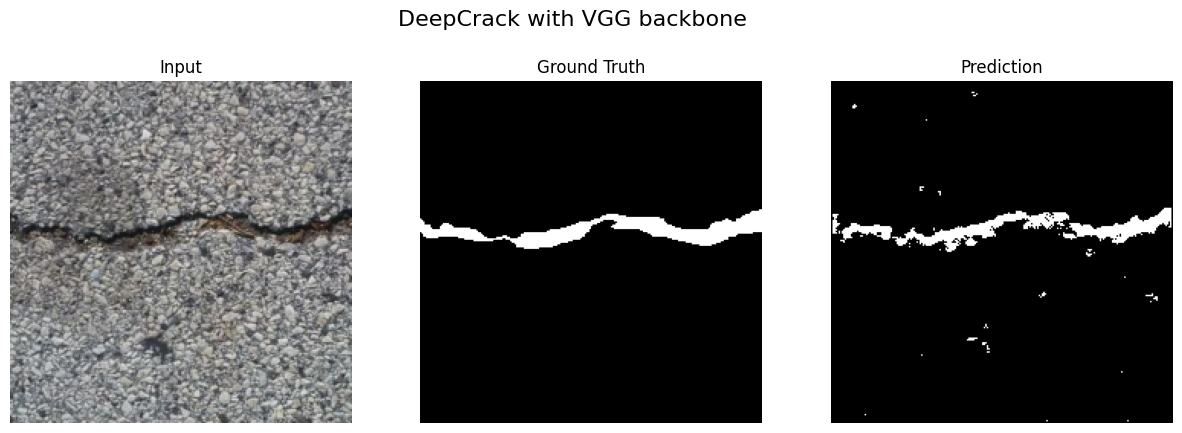


STARTING: DeepCrack with ResNet50 backbone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 
Epoch 1/50 [Train]:   0%|          | 0/375 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 112 but got size 56 for tensor number 3 in the list.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Các tùy chọn cho thử nghiệm ---
NUM_EPOCHS = 50
LEARNING_RATE_SGD = 1e-4
LEARNING_RATE_ADAM = 1e-3

# Danh sách các model để thử nghiệm
models_to_train = {
    "VGG": DeepCrack_VGG,
    "ResNet50": DeepCrack_ResNet50,
    "EfficientNetB0": DeepCrack_EfficientNet
}

all_histories = {}

for model_name, model_class in models_to_train.items():
    experiment_name = f"DeepCrack with {model_name} backbone"
    print(f"\n{'='*20}\nSTARTING: {experiment_name}\n{'='*20}")
    
    # 1. Khởi tạo Model
    model = model_class()
    model = init_net(model, gpu_ids=[0] if torch.cuda.is_available() else [])
    
    # 2. Khởi tạo Loss Function từ Paper
    criterion = DeepCrackLossFromPaper().to(device)
    
    # 3. Khởi tạo Optimizer từ Paper (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE_SGD, momentum=0.9, weight_decay=2e-4)
    # HOẶC: thử với Adam nếu muốn
    # optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_ADAM)

    # 4. Huấn luyện
    model, history = train(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, device)
    all_histories[model_name] = history
    
    # 5. Trực quan hóa kết quả
    visualize(model, val_loader, device, title=experiment_name)

print("\nAll experiments finished.")

In [ ]:
print("Plotting comparison graphs for Resnet-Style Backbone...")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for name, history in vgg_histories.items():
    plt.plot(history['train_loss'], label=name)
plt.title('resnet - Training Loss Comparison')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in vgg_histories.items():
    plt.plot(history['val_iou'], label=name)
plt.title('resnet - Validation IoU Comparison')
plt.xlabel('Epochs'); plt.ylabel('IoU'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()